# Roman Microlensing Data Challenge 2026: Workflow
***
## Learning Goals

By the end of this tutorial, you, the participant, will be able to:

- Load official Data Challenge light curve data from cloud storage.
- Install required software in the Roman Research Nexus (RRN).
- Initialize a submission project using the `microlens-submit` tool.
- Perform a microlensing model fit using `MulensModel`.
- Package your model results, plots, and notes into a standardized solution file.
- Validate and export your final submission for evaluation.

## Introduction

This notebook provides a complete, end-to-end workflow for submitting an entry to the Roman Microlensing Data Challenge 2026 (RMDC26). Following these steps is mandatory for a valid submission.

The process involves accessing data directly from the cloud, performing your analysis within the RRN, and using the `microlens-submit` package to standardize your results. This helps ensure a level playing field and allows the evaluation committee to process all submissions efficiently.

### Important Links
- **microlens-submit documentation:** [Read the Docs](https://microlens-submit.readthedocs.io/en/latest/)
- **RRN teams & servers:** For information on setting up a collaborative team server, please see the teams page
  <img src="../../../../images/icons/team.svg" style="vertical-align: bottom; width:1.5em; margin-right:0.5em;"/> [Working on a Team](../../../../markdown/teams.md)
- **RRN software guide:** [Installing Extra Software](../../../../markdown/software.md)


## 1. Setup: Installing Required Libraries

First, we install the necessary Python packages into our environment. However, we also need to install the Jupyter kernel for that environment, and we need to make sure we keep our package data in a persistent location. This is all handled by the `kernel-create` command or by using a preinstalled kernel such as `roman-cal` or `rges-pit-dc` (not yet installed for all users, but can be created using the `env.yml` in the `data-challenge-notebooks` repository).

In [ ]:
# AAS workshop kernel workaround

# This line assumes you have the entire data-challenge-notebooks repo locally available
!kernel-create rges-pit-dc ../../env.yml "rges-pit-dc"

# Workaround
!conda init bash
!source ~/.bashrc

In [ ]:
# if you are still missing packages, try running this:
!source kernel-activate rges-pit-dc
!conda install ../../env.yml

The following command activates the kernel with all relevant data challenge packages preinstalled, including commonly used modeling tools and the submission management tool.

This line activates the environment in a terminal session:

```python
!source kernel-activate rges-pit-dc  # in a Jupyter notebook cell
```

or

```bash
source kernel-activate rges-pit-dc  # in a terminal
```

However, you still need to select it in the top right corner of this notebook for it to be active here.

If your kernel or conda environment is not showing up in the kernel selection dropdown, ensure the Jupyter `ipykernel` has been installed by running a command like this one in a terminal tab:

```bash
python -m ipykernel install --user --name myenv --display-name "Python (myenv)"
```

Replace `myenv` with your environment name.

<!-- COLAB-ONLY / LOCAL ENVIRONMENT -->
> ### Running outside the Roman Research Nexus
> If you are running this notebook on Google Colab, locally, or in any environment where the `rges-pit-dc` kernel is not pre-configured, run the cell below to install the required packages.
>
> **Note:** In the future, on the Nexus, you will skip this cell because the preinstalled `rges-pit-dc` kernel will already include all dependencies.

In [2]:
# COLAB-ONLY / LOCAL ENVIRONMENT / KERNEL ISSUES
# Uncomment and run if you are NOT on the Roman Research Nexus
%pip install --quiet MulensModel microlens_submit emcee corner matplotlib numpy huggingface_hub

Note: you may need to restart the kernel to use updated packages.


## 2. Imports

Now we import all the libraries we'll need for this workflow.

In [1]:
# system imports
import os
import time
from pathlib import Path

# data access imports
from huggingface_hub import hf_hub_download
import pandas as pd

# display imports
from IPython.display import HTML

# multiprocessing imports
import multiprocessing as mp
from multiprocessing.pool import ThreadPool

# data challenge imports
import microlens_submit
import MulensModel
import emcee

# data analysis/visualization imports
import numpy as np
import matplotlib.pyplot as plt

## 3. Data Access

We will now load a light curve directly from the challenge's public directory. You do not need to download anything for processing on the Nexus; the data is local.

> Future data releases from the Roman Space Telescope will likely be streamed from S3 buckets. You can use `s3fs` to stream the data directly into memory, as shown in the `data_discovery_and_access.md` guide.

In [12]:
TIER = "test"  # "test" "Experienced" "Beginner"
EVENT_ID = "data_challenge_0_129_335"  # "we don't have a canonical naming system yet"
FILENAME = f"{EVENT_ID}.det.lc"

In [13]:
# NEXUS-ONLY
# This is the official, secure path to the data challenge files on the Nexus.
DATA_DIR = "/data/data-challenge/rges"
#DATA_URI = f"{DATA_DIR}/{TIER}/{FILENAME}"
DATA_URI = f"{DATA_DIR}/{FILENAME}"  # currently includes only the AAS test set

# Load the data with header and band column
lc_data = pd.read_csv(DATA_URI, sep=r'\s+', comment='#', header=0)

In [16]:
# Alternate data store
REPO_ID = f"RGES-PIT/{TIER}"

lc_data = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=FILENAME, repo_type="dataset"), sep=r'\s+', comment='#', header=0
)

data_challenge_0_129_335.det.lc:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

We'll make a plot now, to check that whichever data retrieval method you are using is working as expected

Bands found: [0 1 2]


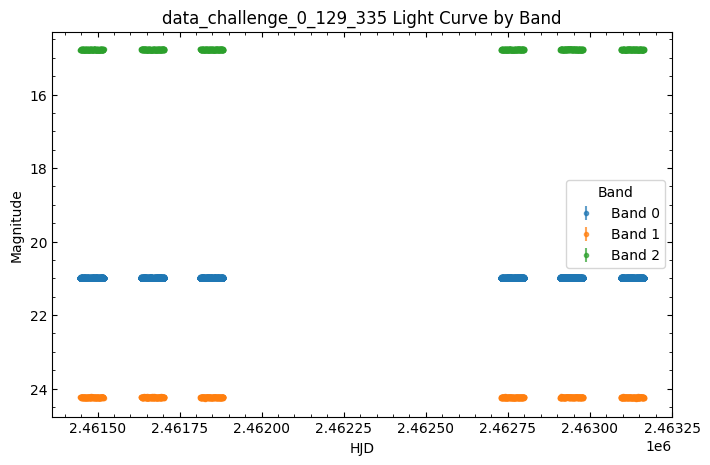

In [17]:
# Get unique bands (`observatory_code`)
bands = np.sort(np.unique(lc_data['observatory_code']))
print(f"Bands found: {bands}")

# calculate magnitude
def gulls_flux_to_mag(df, fs, Obssrcmag, bands):
    """Calculate mag and mag_err for Gulls lightcurves (baseline-relative flux)."""
    # gulls uses a relative flux such that baseline is always 1 and the flux-system zeropoint changes for each event
    f    = df["measured_relative_flux"].to_numpy()
    ferr = df["measured_relative_flux_error"].to_numpy()
    obs  = df["observatory_code"].to_numpy()

    # Per-band zero-point (fs and Obssrcmag must be aligned with `bands` order)
    m0_per_band = 2.5 * np.log10(fs) + Obssrcmag
    m0_map = dict(zip(bands, m0_per_band))

    # Map each row's band -> m0
    m0 = np.vectorize(m0_map.get)(obs)

    # Magnitude + error propagation
    mag = m0 - 2.5 * np.log10(f)
    mag_err = (2.5 / np.log(10.0)) * (ferr / f)

    df = df.copy()
    df["mag"] = mag
    df["mag_err"] = mag_err
    return df

# from the data file comments we know that: #fs:
fs = np.array([0.0858942, 0.991581, 0.000266992])
Obssrcmag = np.array([23.6466, 24.2485, 23.7078])

lc_data = gulls_flux_to_mag(lc_data, fs, Obssrcmag, bands)

# Plot each band separately
plt.figure(figsize=(8, 5))
for band in bands:
    mask = lc_data["observatory_code"] == band
    plt.errorbar(
        lc_data["BJD"][mask], lc_data["mag"][mask], yerr=lc_data["mag_err"][mask],
        fmt=".", label=f"Band {band}", alpha=0.7
    )

plt.gca().invert_yaxis()
plt.title(f"{EVENT_ID} Light Curve by Band")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.legend(title="Band")
plt.show()

## 4. Initialize Your Submission Project

To initialize a submission object in Python, use `microlens_submit.load(project_path)`.
If the directory at `project_path` does not exist, it will be created with the correct structure and a blank submission.
You can then set the required metadata (like `team_name`, `tier`, etc.) on the returned `Submission` object, and call `.save()` to persist it.

In [18]:
# Define your project directory in your persistent home folder
#TEAM_NAME = "The Transiting Poachers"  # Nexus team name
TEAM_NAME = "rges-pit"
project_path = Path(f"/teams/{TEAM_NAME}/")

# To locate your submission project in the current working directory, use:
# project_path = Path.cwd() / TEAM_NAME
# To locate your submission project in your home directory, use:
# project_path = Path.home() / TEAM_NAME

# Now, load the project into our session
submission = microlens_submit.load(project_path)  # creates the project directory if it doesn't exist
submission.team_name = TEAM_NAME  # assuming your Nexus team name is the same as your data-challenge team name
submission.tier = TIER
print(f"\nProject for '{submission.team_name}' loaded successfully.")

# You can expect saving at this point to result in warnings about missing info
submission.save()


Project for 'rges-pit' loaded successfully.
⚠️  Save completed with validation warnings:
   repo_url is required (GitHub repository URL)
   Hardware info is missing
💡 Fix validation errors before exporting for submission
💾 Submission saved locally (incomplete - not ready for submission)
✅ Successfully saved submission to disk


After initializing or loading your microlens-submit project, and initializing your linked git repository, simply set the repo_url attribute on your Submission. If the directory already exists, load() will just load the existing project, not overwrite it. If the directory exists but no submission content, the content will be added when you run `submission.save()`.

In [19]:
# initialize your git repo
#!git init
#!git add .
#!git commit -m "Initial commit"
#!git branch -m main
#!git remote add origin https://github.com/yourusername/your-repo.git
#!git push -u origin main

# set the repo url in the submission object
submission.repo_url = "https://github.com/yourusername/your-repo.git"

> You may leave this repository private during the data challenge, but we ask that you make it public once submissions close, to ensure it is accessible to evaluators.

If you want to auto-populate your hardware info and are using the Nexus (like the CLI `nexus-init` command does), you can call the method:

In [20]:
# add your hardware info
submission.autofill_nexus_info()

This will attempt to detect and fill in hardware details if running in the Roman Science Platform environment, but you can always set or override any values manually.

```python
# add your hardware info
submission.hardware_info = {
    "cpu_model": "Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz",
    "num_cores": 16,
    "memory_gb": 64,
    "platform": "Linux",
    # ...any other relevant info
}
```

A valid submission will include the attributes:
* `team_name` to know who the submission belongs to
* `tier` to validate event IDs
* `repo_url` for reproducibility and evaluation
* `hardware_info` for benchmarking purposes

You can continue to edit your project without all of this information to make it "valid", but you will not be able to submit. You can check the submission validity of your entire project at any time using `submission.run_validation()`.

## Alternative: Command Line Interface (CLI)

If you prefer using the command line or want to automate parts of your workflow, you can accomplish the same tasks using the `microlens-submit` CLI. The CLI is particularly useful for batch processing and automation.

### Nexus-Specific CLI Commands

The following commands are specifically designed for the Roman Research Nexus environment:

#### 1. Initialize Project with Nexus Hardware Info

The `nexus-init` command automatically detects and records your Nexus environment details:

```bash
# Initialize project with automatic Nexus hardware detection
microlens-submit nexus-init --team-name "Your Team" --tier "2018-test" ./my_dc2_submission

# This command will automatically detect:
# - CPU model from /proc/cpuinfo
# - Memory from /proc/meminfo
# - Nexus image from JUPYTER_IMAGE_SPEC
# - Platform information
```

#### 2. Set Hardware Information Manually

You can also set hardware information manually using the `set-hardware-info` command:

```bash
# Set CPU information
microlens-submit set-hardware-info --cpu "Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz" \
    --memory-gb 64 --platform "Roman Research Nexus" \
    --nexus-image "roman-dc2:latest"

# Or set individual components
microlens-submit set-hardware-info --cpu-details "16-core Intel Xeon" \
    --ram-gb 64 --platform "Roman Science Platform"
```

### Complete CLI Workflow Example

Here's how to accomplish the same tasks using the command-line interface:

```bash
# 1. Initialize project with Nexus hardware info
microlens-submit nexus-init --team-name "The Transiting Poachers" --tier "2018-test" ./my_dc2_submission

# 2. Add a solution with parameters
microlens-submit add-solution ulwdc1_001 1S1L \
    --param t0=2459123.5 --param u0=0.15 --param tE=20.5 \
    --log-likelihood -1234.56 --n-data-points 1250 \
    --cpu-hours 15.2 --wall-time-hours 3.8 \
    --lightcurve-plot-path plots/ulwdc1_001_lc.png \
    --lens-plane-plot-path plots/eulwdc1_001_lens.png \
    --notes "Initial PSPL fit using MulensModel and emcee"

# 3. Add a more complex solution
microlens-submit add-solution ulwdc1_001 1S2L \
    --param t0=2459123.5 --param u0=0.12 --param tE=22.1 \
    --param q=0.001 --param s=1.15 --param alpha=45.2 \
    --log-likelihood -1189.34 --n-data-points 1250 \
    --cpu-hours 28.5 --wall-time-hours 7.2 \
    --alias "planetary_fit" \
    --notes "Binary lens fit with planetary companion"

# 4. Compare solutions
microlens-submit compare-solutions ulwdc1_001

# 5. Validate your submission
microlens-submit validate-submission

# 6. Generate dossier for review
microlens-submit generate-dossier

# 7. Export final submission
microlens-submit export final_submission.zip
```

### CLI vs Python API

**When to use CLI:**
- Batch processing multiple events
- Automation and scripting
- Quick parameter updates
- Command-line workflows
- Integration with other tools

**When to use Python API:**
- Interactive analysis in Jupyter notebooks
- Complex data processing
- Custom validation logic
- Integration with scientific Python ecosystem

### Additional CLI Resources

For a comprehensive CLI tutorial, see the [Command Line Tutorial](https://microlens-submit.readthedocs.io/en/latest/tutorial.html) in the documentation.

For detailed API reference, see the [API Documentation](https://microlens-submit.readthedocs.io/en/latest/api.html).

In [21]:
# save the project
submission.save()

✅ Submission saved successfully (ready for export)
✅ Successfully saved submission to disk


The result in a project directory of the following structure:

```
   <project_dir>/
   ├── submission.json
   └── events/
```

As you add events, solutions, notes, and figures they will be populated inside this project as follows:

```
   <submission_dir>/
   ├── dossier/
   ├       ├── index.html
   ├       ├── <event_id>.html
   ├       ├── <solution_id>.html 
   ├       ├── full_report.html 
   ├       └── assets/
   ├── submission.json
   └── events/
       └── <event_id>/
           ├── event.json
           └── solutions/
               ├── <lightcurve image>  # your generated lightcurve plots (optional)
               ├── <lens plane image>  # your generated lens-plane diagram (optional)
               ├── <posteriors>.csv    # your generated posteriors (optional)
               ├── <solution_id>.md    # your notes (optional)
               └── <solution_id>.json
```

> A note for later: We recommend you save generated lightcurve plots, lens-plane diagrams, and notes according to this format, but the submission tool is flexible to all save locations, so long as you include the relative path to your <project_dir> in the <solution_id>.json (accessed through the microlens_submit tool or manually). 

## 5. Microlensing Model Fitting

This is where the science happens. Define your `MulensModel` and use your preferred fitting algorithm (e.g., MCMC) to find the best-fit parameters for the event data. 

### 5.1. Define the Model
As an example, we are going to do a preliminary fit using only one band and a point-source-point-lens model.

In [23]:
# 5.1. Define the model (e.g., Point Source Point Lens)
# Use only the first band for this preliminary fit
first_band = bands[0]
band_mask = lc_data["observatory_code"] == first_band
band_data = lc_data[band_mask]

# Create MulensModel data object for the first band
my_data = MulensModel.MulensData(
    data_list=[band_data['BJD'], 
               band_data['mag'], 
               band_data['mag_err']],
    phot_fmt='mag',
    bandpass='H'  # randomly chosen - not indicative of the true band color
)

# Initial model parameters (no parallax for preliminary fit)
initial_params = {
    't_0': band_data['BJD'][np.argmin(band_data['mag'])],
    'u_0': 0.1,
    't_E': 25.,
}

pspl_model = MulensModel.Model(initial_params)

# Create the event object
event_object = MulensModel.Event(datasets=my_data, model=pspl_model)

### 5.2. Setting up the Fitting Procedure

We will use `emcee` to drive this fit, so we can demonstrate more attributes of the submission object, like the `posterior_path` and `cpu_time` vs `wall_time`.

In [24]:
# 5.2. Define the likelihood function for emcee
def log_likelihood(theta, event_object, parameters_to_fit):
    """Log likelihood function for emcee"""
    try:
        # Update model parameters
        for i, param_name in enumerate(parameters_to_fit):
            if param_name == 'log_rho':
                # Convert log_rho back to rho
                event_object.model.parameters.rho = 10**theta[i]
            else:
                setattr(event_object.model.parameters, param_name, theta[i])
        
        # Fit the fluxes given the current model parameters
        event_object.fit_fluxes()
        
        # Get the source and blend fluxes
        ([F_S], F_B) = event_object.get_flux_for_dataset(event_object.datasets[0])
        
        # Calculate chi-squared
        chi2 = event_object.get_chi2()
        
        # Add flux priors if needed (optional)
        penalty = 0.0
        if F_B <= 0:
            penalty = ((F_B / 100)**2)  # Penalize negative blend flux
        if F_S <= 0 or (F_S + F_B) <= 0:
            return -np.inf  # Return inf if fluxes are non-physical
        
        return -0.5 * chi2 - penalty
    except:
        return -np.inf

# Set up emcee
nwalkers = 32
ndim = 3  # t_0, u_0, t_E
nsteps = 1000
burnin = 200

### 5.3. Performing the Fit

We will use multithreading with `ThreadPool` from the `multiprocessing` library for this fit, because it is more compatible with notebooks. However, it caches the state of your notebook and can cause unexpected behaviors when you edit code related to your fit and re-run. It is a better idea to use a script and multiprocessing using the `Pool` function.

In [25]:
# 5.3. Run MCMC fitting
print("Starting MCMC fit...")
start_time = time.time()
start_cpu = time.process_time()

# Set up parameters to fit
parameters_to_fit = ["t_0", "u_0", "t_E"]
ndim = len(parameters_to_fit)

# Initial positions (slightly perturbed from initial guess)
pos = np.array([
    initial_params['t_0'], initial_params['u_0'], initial_params['t_E']
]) + 1e-4 * np.random.randn(nwalkers, ndim)

# Use ThreadPool instead of Pool for notebooks
n_cores = mp.cpu_count()
print(f"Using {n_cores} threads for MCMC")

# Create the thread pool
with ThreadPool(processes=n_cores) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_likelihood, 
        args=(event_object, parameters_to_fit),
        pool=pool
    )
    sampler.run_mcmc(pos, nsteps, progress=True)

# Calculate timing
wall_time_hours = (time.time() - start_time) / 3600
cpu_time_hours = (time.process_time() - start_cpu) / 3600

# Get "best fit" parameters (median of posterior)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
best_fit_params = {
    "t0": np.median(samples[:, 0]),
    "u0": np.median(samples[:, 1]),
    "tE": np.median(samples[:, 2]),
}

# Update the model with best fit parameters and calculate fluxes
for i, param_name in enumerate(parameters_to_fit):
    setattr(event_object.model.parameters, param_name, best_fit_params[f"t{param_name[2:]}" if param_name.startswith('t_') else param_name.replace('_', '')])

# Fit fluxes using MulensModel
event_object.fit_fluxes()
([F_S], F_B) = event_object.get_flux_for_dataset(event_object.datasets[0])

best_fit_params[f"F{first_band}_S"] = F_S
best_fit_params[f"F{first_band}_B"] = F_B

# Calculate log likelihood at best fit
best_log_likelihood = log_likelihood([
    best_fit_params["t0"], 
    best_fit_params["u0"], 
    best_fit_params["tE"]
], event_object, parameters_to_fit)

n_data_points = len(my_data.time)

print(f"Best-fit parameters obtained: {best_fit_params}")
print(f"Wall time: {wall_time_hours:.3f} hours")
print(f"CPU time: {cpu_time_hours:.3f} hours")

Starting MCMC fit...
Using 2 threads for MCMC


100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]

Best-fit parameters obtained: {'t0': np.float64(2462933.8850844353), 'u0': np.float64(0.29534953358764326), 'tE': np.float64(24.77757137849003), 'F0_S': np.float64(0.0029434231433999275), 'F0_B': np.float64(2.5520579782323085)}
Wall time: 0.129 hours
CPU time: 0.154 hours


While that's running, consider consulting the [`microlens-submit` documentation](https://microlens-submit.readthedocs.io/en/latest/submission_manual.html) for details on the submission structure. You can add solutions as you progress with your analysis or collect like-models in csv files and use the bulk-csv-import function. The documentation includes more detailed instructions for building your own submission [manually](https://microlens-submit.readthedocs.io/en/latest/submission_manual.html#manual-submission-format), using the [python API](https://microlens-submit.readthedocs.io/en/latest/api.html), using the [CLI tool](https://microlens-submit.readthedocs.io/en/latest/tutorial.html), and using the [csv bulk import procedure](https://microlens-submit.readthedocs.io/en/latest/submission_manual.html#csv-import-format). 

The sumission tool will check that you meet all sumission requirements and that your inputs for a model, solution, event, or tier are as expected. It also creates html dossiers that allows you to inspect your progress.

You can choose for yourself how integrated you want the tool to be in your workflow, but submissions intended for evalutation should pass validation. This ensure that we can partially automate the evaluation process, quantitatively assesing your submission accuracy compared with select simulation truths. 

If you run in to issues with the tool, contact the developer through the [RMDC26 Slack Workspace](rmdc26.slack.com), [GitHub Issues](https://github.com/rges-pit/microlens-submit/issues), or on the [RGES-PIT website help form](https://rges-pit.org/data-challenge/help/). 

> This tool is under active development and feedback or feature requests are welcome. Updates such as dossier plots can be expected during the challenge so we recommend you periodically update the package; `pip install -U microlens_submit`

### 5.4. Results
Let's save and plot all the fit results.

In [27]:
# 5.4. Create the initial solution and event objects
event = submission.get_event(EVENT_ID)
solution = event.add_solution(
    model_type="1S1L",
    parameters=best_fit_params,
    alias=f"Preliminary PSPL - Band {first_band}"
)
solution.bands = ["0"]

# We are doing this now because we want generated solution id for our file paths

✅ Created solution 0096937d-dd91-4952-ab87-8c1a50cd30bd with alias 'Preliminary PSPL - Band 0'
   Model: 1S1L, Parameters: 5
   ⚠️  Note: Alias 'Preliminary PSPL - Band 0' will be validated for uniqueness when saved
   💾 Remember to call submission.save() to persist to disk


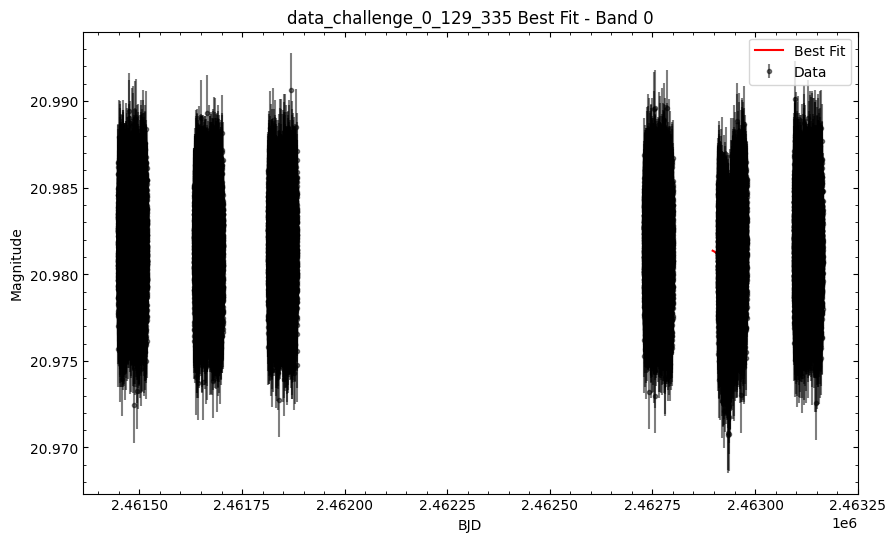

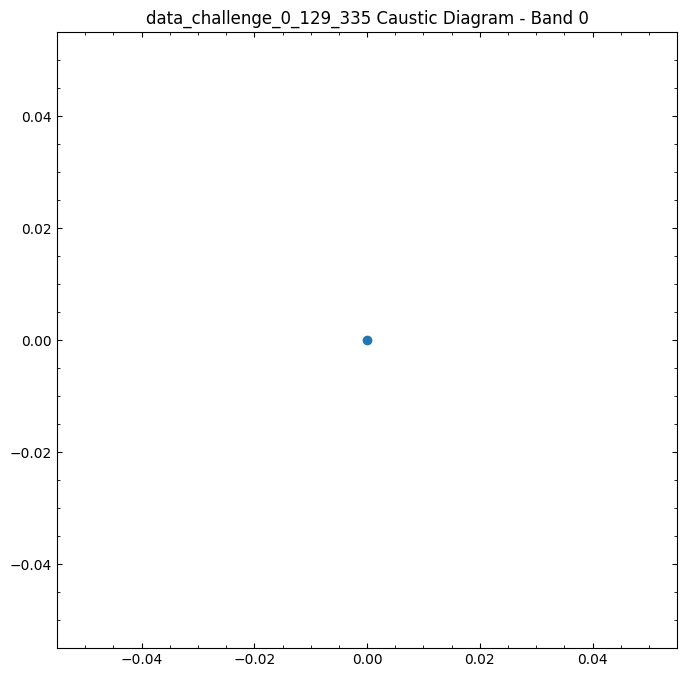

In [29]:
# Save posteriors
posterior_dir = Path(project_path) / "events" / EVENT_ID / "solutions" / solution.solution_id
posterior_dir.mkdir(parents=True, exist_ok=True)
posterior_path = posterior_dir / "posteriors.csv"

# Save posterior samples with column headers (no parallax parameters)
posterior_data = np.column_stack([
    samples[:, 0], samples[:, 1], samples[:, 2]
])
np.savetxt(posterior_path, posterior_data, 
           delimiter=',', 
           header='t0,u0,tE',
           comments='')

# Save lightcurve plot
plt.figure(figsize=(10, 6))
plt.errorbar(my_data.time, my_data.mag, yerr=my_data.err_mag, fmt='.', 
             color='k', alpha=0.5, label='Data')

# Plot best fit model using the event object
event_object.plot_model(color='r', label='Best Fit')
plt.legend()
plt.gca().invert_yaxis()
plt.title(f"{EVENT_ID} Best Fit - Band {first_band}")
plt.xlabel("BJD")
plt.ylabel("Magnitude")

lightcurve_path = posterior_dir / "lightcurve.png"
plt.savefig(lightcurve_path, dpi=150, bbox_inches='tight')
plt.show()

# Save caustic diagram (for PSPL, this will be empty since no caustics)
plt.figure(figsize=(8, 8))
event_object.model.plot_caustics()
plt.title(f"{EVENT_ID} Caustic Diagram - Band {first_band}")
caustic_path = posterior_dir / "caustic.png"
plt.savefig(caustic_path, dpi=150, bbox_inches='tight')
plt.show()

### 5.5 Solution Management

Now, we package these results into the submission object.

A solution entry has the following attributes:
* `model_type`
* `parameters` matching the indicated `model_type` and `higher_order_effects`
* `higher_order_effects` (if any are present in the model)
* `log_likelihood` (the fit's log-likelihood value; $-\chi^2/2$)
* `relative_probability` (optional, probability of this solution being the true model)
* `n_data_points` (number of data points used in the fit)
* `compute_info` containing:
  - `cpu_hours`
  - `wall_time_hours`
  - `dependencies` (list of installed Python packages, auto-captured)
  - `git_info` (commit, branch, is_dirty; auto-captured if in a git repo)
* `t_ref` (reference time, if required for indicated higher-order effects)
* `bands` (if the fit is band-dependent)
* `alias` (optional, for human-readable, editable solution names)
* `notes_path` (path to Markdown notes file, optional but recommended)
* `parameter_uncertainties` (uncertainties for parameters)
* `physical_parameters` (optional, derived physical parameters)
* `posterior_path` (optional, path to posterior samples)
* `lightcurve_plot_path` (optional, path to lightcurve plot image)
* `lens_plane_plot_path` (optional, path to lens plane plot image)
* `used_astrometry` (optional, whether astrometric data was used)
* `used_postage_stamps` (optional, whether postage stamp data was used)
* `limb_darkening_model` and limb_darkening_coeffs (if relevant)

A solution requires only these fields for validity:
* `model_type`
* `parameters` matching the indicated `model_type` with no `higher_order_effects`
* `log_likelihood` (the fit's log-likelihood value; $-\chi^2/2$)
* `n_data_points` (number of data points used in the fit)
* `compute_info` containing at least:
  - `cpu_hours`
  - `wall_time_hours`

You can set these `compute_info` values using the method:
`solution.set_compute_info(cpu_hours=..., wall_time_hours=...)`
This method also captures:
* The current Python environment (pip freeze output)
* Git repository info (commit, branch, dirty status)
* You can call `set_compute_info()` with either or both values, or leave them blank if you want only the environment info.

We calculated these compute times in the previous section using `time.time()` and `time.process_time()`. `time.time()` records the literal time, whereas `time.process_time()` returns the total CPU time (in seconds) that the current process has used since it started. So calculating the difference between two `time.time()` calls will tell you the time elapsed (in seconds) between each call, while the difference between two `time.process_time()` calls will tell you the CPU time elapsed, not including time spent sleeping or waiting for I/O. For example, for a process with 4 cores, running for 1 hour, this would mean a CPU time of 4 hours.

In [40]:
# Set compute info
# automatically detects the current python environment and git repository state
solution.set_compute_info(cpu_hours=cpu_time_hours, wall_time_hours=wall_time_hours)

# Set other metadata
solution.log_likelihood = best_log_likelihood
solution.n_data_points = n_data_points
solution.bands = [str(first_band)]

# Set file references
solution.posterior_path = str(posterior_path.relative_to(project_path))
solution.lightcurve_plot_path = str(lightcurve_path.relative_to(project_path))
solution.lens_plane_plot_path = str(caustic_path.relative_to(project_path))

# Set notes
solution.set_notes(f"""
# Preliminary Fit Analysis

This is a preliminary PSPL fit to determine approximate parameters.

## Fit Details
- **Model Type**: 1S1L
- **Band Used**: {first_band}
- **Data Points**: {n_data_points}
- **MCMC Walkers**: {nwalkers}
- **MCMC Steps**: {nsteps}
- **Burn-in**: {burnin} steps

This solution is marked as inactive as it represents a preliminary analysis.
""")

# Save everything
submission.save()

print(f"✅ Solution '{solution.alias}' ({solution.solution_id}) created and saved!")
print(f"   - Posteriors saved to: {posterior_path}")
print(f"   - Lightcurve plot saved to: {lightcurve_path}")
print(f"   - Caustic diagram saved to: {caustic_path}")
print(f"   - Solution marked as inactive")

⚠️  Save completed with validation warnings:
   Event 'data_challenge_0_129_335' is not valid for tier 'test' (Testing tier for development). Valid events for this tier: ['evt', 'test-event']
💡 Fix validation errors before exporting for submission
💾 Submission saved locally (incomplete - not ready for submission)
✅ Successfully saved 2 new solution(s) to disk
📋 Saved aliases: data_challenge_0_129_335 bad solution, data_challenge_0_129_335 Preliminary PSPL - Band 0
✅ Solution 'Preliminary PSPL - Band 0' (0096937d-dd91-4952-ab87-8c1a50cd30bd) created and saved!
   - Posteriors saved to: /teams/rges-pit/events/data_challenge_0_129_335/solutions/0096937d-dd91-4952-ab87-8c1a50cd30bd/posteriors.csv
   - Lightcurve plot saved to: /teams/rges-pit/events/data_challenge_0_129_335/solutions/0096937d-dd91-4952-ab87-8c1a50cd30bd/lightcurve.png
   - Caustic diagram saved to: /teams/rges-pit/events/data_challenge_0_129_335/solutions/0096937d-dd91-4952-ab87-8c1a50cd30bd/caustic.png
   - Solution marke

### 5.6 Solution Comparison and Relative Probability

When you have multiple solutions for the same event, you can specify their relative probabilities to indicate which model you think is most likely to be correct.

**Key Points:**
* **Relative probabilities must sum to 1.0** across all active solutions for an event
* **If you don't specify relative probabilities**, they are automatically calculated during export using the Bayesian Information Criterion (BIC)
* **BIC calculation** uses: `BIC = k*ln(n) - 2*log_likelihood` where k = number of parameters, n = number of data points
* **Equal probabilities** are assigned if BIC calculation is not possible (missing data)

**Example of manual relative probability assignment:**

In [41]:
# Example: If you have multiple solutions for the same event
# solution1.relative_probability = 0.7  # 70% confidence
# solution2.relative_probability = 0.3  # 30% confidence
# Total must equal 1.0

# For this example, we'll just note that relative probability is optional
# and will be calculated automatically if not provided
print("Relative probability will be calculated automatically during export if not specified.")
print("The calculation uses BIC: BIC = k*ln(n) - 2*log_likelihood")
print("where k = number of parameters, n = number of data points")

Relative probability will be calculated automatically during export if not specified.
The calculation uses BIC: BIC = k*ln(n) - 2*log_likelihood
where k = number of parameters, n = number of data points


**How automatic calculation works during export:**
1. **If you provide relative probabilities** that sum to 1.0, those are used
2. **If some solutions have relative probabilities** but others don't, the remaining probability is distributed among the unspecified solutions using BIC
3. **If no solutions have relative probabilities**, all active solutions get equal probability
4. **If BIC calculation fails** (missing log_likelihood, n_data_points, or parameters), equal probabilities are assigned

This ensures that evaluators always have a complete probability distribution for your solutions.

## 6. Dossier and Solution Management

This is the final step. We will generate a human-readable HTML report (a 'dossier'), validate the submission for completeness, and export the final `.zip` file to the official submission location.

In [42]:
# 1. Create the HTML Dossier for your own records
from microlens_submit.dossier import generate_dashboard_html

dossier_path = project_path / "dossier"
generate_dashboard_html(submission, dossier_path, open=False)
print(f"HTML Dossier report generated at: {dossier_path}/index.html")

HTML Dossier report generated at: /teams/rges-pit/dossier/index.html


### 6.1. Display the Dashboard

In [43]:
# Display the dashboard inline (requires IPython)

# Read the generated HTML file
with open(dossier_path / "index.html", "r", encoding="utf-8") as f:
    html = f.read()

# Show the dashboard in the notebook 
HTML(html)

# Note: images paths not resolving correctly for submission not in the same folder as the notebook is a known issue currently being addressed. 

Event ID,Active Solutions,Model Types Submitted
data_challenge_0_129_335,1,1S1L


### 6.2. Display the Event Page

In [44]:
# Read the generated HTML file
with open(dossier_path / f"{event.event_id}.html", "r", encoding="utf-8") as f:
    html = f.read()

# Show the dashboard in the notebook
HTML(html)

Solution ID,Model Type,Status,Log-Likelihood,N Data Points,Relative Probability,Notes Snippet
Preliminary PSPL - Band 0 0096937d...,1S1L,Active,-23199.57,46208,N/A,
bad solution 26b68f47...,1S1L,Inactive,N/A,N/A,N/A,


### 6.3. Display the Solution Page

In [45]:
# Read the generated HTML file
with open(dossier_path / f"{solution.solution_id}.html", "r", encoding="utf-8") as f:
    html = f.read()

# Show the dashboard in the notebook
HTML(html)

### 6.4. Display Full Report

This is the report that will be generated for the evaluators, with placeholders for sections that are not meant for participants. You can generate this report to view the full state of your project as you go, in the format in which it will be evaluated.

```python
# Read the generated HTML file
with open(dossier_path / "full_dossier_report.html", "r", encoding="utf-8") as f:
    html = f.read()

# Show the dashboard in the notebook
HTML(html)
```

### But what if you don't like a fit?

You can soft delete a fit without removing it from your local project by deactivating it:

In [47]:
# Deactivate the solution
# we are doing this because this is a preliminary fit and we don't want it to 
# be used in the final report
solution.is_active = False

You can also hard delete a solution by calling `event.remove_solution(solution_id, force=True)` or navigating to the solution in the project directory and delete it manually.

For these changes to persist outside of the active python objects, you must again save the submission.

In [48]:
submission.save()

⚠️  Save completed with validation warnings:
   Event 'data_challenge_0_129_335' is not valid for tier 'test' (Testing tier for development). Valid events for this tier: ['evt', 'test-event']
   Event data_challenge_0_129_335: Event data_challenge_0_129_335 has no active solutions
💡 Fix validation errors before exporting for submission
💾 Submission saved locally (incomplete - not ready for submission)
✅ Successfully saved submission to disk
📋 Saved aliases: data_challenge_0_129_335 bad solution, data_challenge_0_129_335 Preliminary PSPL - Band 0


## 7. Validation and Submitting the Project

This is the final step. We will validate the submission for completeness, and export the final `.zip` file to the official submission location.

In [50]:
# 1. Validate the submission
print("\nRunning validation...")
warnings = submission.run_validation()
if warnings:
    print("⚠️ Validation Warnings Found:")
    for w in warnings:
        print(f"  - {w}")
else:
    print("✅ Submission is valid and ready for export!")

# 2. Export the final submission file

full_output_path = f"~/"

print(f"\nExporting submission to: {full_output_path}")
try:
    local_export_path = project_path / "final_submission"
    submission.export(str(local_export_path))
    print(f"\n🎉 Successfully exported to {local_export_path}")
    print("You would now upload this file to the secure submission location.")
except ValueError as e:
    print(f"❌ Export failed: {e}")

# That bit's a trick. It doesn't actually go anywhere.
# We will collect the most recent submission zip in your team storage on the RRN
# for you. No need to do anything. 🥳


Running validation...
⚠️ Validation Warnings Found:
  - Event 'data_challenge_0_129_335' is not valid for tier 'test' (Testing tier for development). Valid events for this tier: ['evt', 'test-event']
  - Event data_challenge_0_129_335: Event data_challenge_0_129_335 has no active solutions

Exporting submission to: ~/
❌ Export failed due to validation errors:
   Event 'data_challenge_0_129_335' is not valid for tier 'test' (Testing tier for development). Valid events for this tier: ['evt', 'test-event']
   Event data_challenge_0_129_335: Event data_challenge_0_129_335 has no active solutions
💡 Fix validation errors before exporting for submission
💡 Use submission.save() to save incomplete work locally
❌ Export failed: Validation failed:
Event 'data_challenge_0_129_335' is not valid for tier 'test' (Testing tier for development). Valid events for this tier: ['evt', 'test-event']
Event data_challenge_0_129_335: Event data_challenge_0_129_335 has no active solutions


In [ ]:
the validation fails because the tool is not expecting `data_challenge_0_129_335` in

## Additional Resources
- [Roman Research Nexus: Data Discovery & Access](https://spacetelescope.github.io/roman-notebooks/notebooks/data_discovery_and_access/data_discovery_and_access.html)
- [Session A — Nexus Setup & Help (AAS Workshop site)](https://rges-pit.org/data-challenge/aas-workshop/1-nexus/)
- [Roman Microlensing Data Challenge landing page](https://rges-pit.org/data-challenge/)
- [microlens-submit documentation](https://microlens-submit.readthedocs.io/en/latest/)
- [Next notebook: Session B — Single Lens & Pipelines](https://github.com/rges-pit/data-challenge-notebooks/blob/main/AAS%20Workshop/Session%20B%3A%20Single%20Lens%20%26%20Pipelines/Single_Lens_Pipeline.ipynb)



## Appendix: Working with Parquet Files

The Roman Microlensing Data Challenge may provide data in **Parquet** format, a columnar storage format that is highly efficient for large datasets. This appendix covers the basics of reading, writing, and working with Parquet files in Python.

### Why Parquet?

- **Efficient storage**: Parquet uses columnar compression, significantly reducing file sizes compared to CSV.
- **Fast read performance**: Only the columns you need are loaded into memory.
- **Schema preservation**: Data types are preserved, avoiding issues with type inference.
- **Compatibility**: Works seamlessly with pandas, PyArrow, and cloud storage (S3).

### Installing Required Packages

If you don't already have `pyarrow` or `fastparquet` installed, you can install them with:

In [ ]:
# Install pyarrow (recommended) or fastparquet
# Uncomment the line below if needed
!pip install pyarrow

### Reading Parquet Files

#### Basic Reading with pandas

In [ ]:
import pandas as pd

# Read a local Parquet file
df = pd.read_parquet("path/to/file.parquet")

# Read only specific columns (more memory efficient)
df = pd.read_parquet("path/to/file.parquet", columns=["HJD", "mag", "mag_err", "band"])

# Example: Display the first few rows
df.head()

#### Reading Parquet from S3 (Cloud Storage)

For data stored in S3 buckets (like the Data Challenge data), you can read Parquet files directly:

In [ ]:
import s3fs
import pandas as pd

# Connect to S3 (anonymous access for public buckets)
fs = s3fs.S3FileSystem(anon=True)

# Read a Parquet file directly from S3
PARQUET_URI = "s3://rmdc26-data-public/example/lightcurve.parquet"
with fs.open(PARQUET_URI, 'rb') as f:
    df = pd.read_parquet(f)

# Alternative: Use pandas with storage_options
df = pd.read_parquet(
    "s3://rmdc26-data-public/example/lightcurve.parquet",
    storage_options={"anon": True}
)

### Writing Parquet Files

Saving your processed data or results as Parquet is straightforward:

In [ ]:
# Create a sample DataFrame
sample_data = pd.DataFrame({
    "event_id": ["event_001", "event_002", "event_003"],
    "t0": [2459000.5, 2459100.2, 2459200.8],
    "tE": [25.3, 42.1, 18.7],
    "u0": [0.1, 0.05, 0.2],
    "classification": ["PSPL", "Binary", "PSPL"]
})

# Save to Parquet with default compression (snappy)
sample_data.to_parquet("results.parquet", index=False)

# Save with gzip compression (smaller file, slower read/write)
sample_data.to_parquet("results.parquet", index=False, compression="gzip")

print("Sample DataFrame:")
sample_data

### Inspecting Parquet File Metadata

You can inspect a Parquet file's schema and metadata without loading the entire file:

In [ ]:
import pyarrow.parquet as pq

# Read metadata without loading data
parquet_file = pq.ParquetFile("path/to/file.parquet")

# Get schema (column names and types)
print("Schema:")
print(parquet_file.schema_arrow)

# Get number of rows without reading the data
print(f"\nNumber of rows: {parquet_file.metadata.num_rows}")

# Get number of row groups
print(f"Number of row groups: {parquet_file.metadata.num_row_groups}")

### Working with Large Parquet Datasets

For datasets too large to fit in memory, you can process them in chunks:

In [ ]:
# Read Parquet file in batches using PyArrow
parquet_file = pq.ParquetFile("large_dataset.parquet")

# Process one row group at a time
for batch in parquet_file.iter_batches(batch_size=10000):
    df_chunk = batch.to_pandas()
    # Process each chunk
    print(f"Processing {len(df_chunk)} rows...")

# Alternative: Read row groups individually
for i in range(parquet_file.metadata.num_row_groups):
    table = parquet_file.read_row_group(i)
    df_chunk = table.to_pandas()
    # Process each row group

### Converting Between Formats

#### CSV to Parquet

In [ ]:
# Convert CSV to Parquet
df = pd.read_csv("lightcurve.csv")
df.to_parquet("lightcurve.parquet", index=False)

# Convert Parquet to CSV
df = pd.read_parquet("lightcurve.parquet")
df.to_csv("lightcurve.csv", index=False)

print("Conversion examples shown above (uncomment to run)")

### Tips for Working with Parquet in the Data Challenge

1. **Use column selection**: When reading large files, only load the columns you need:
   ```python
   df = pd.read_parquet("file.parquet", columns=["HJD", "mag", "mag_err"])
   ```

2. **Leverage filtering**: PyArrow supports predicate pushdown for efficient filtering:
   ```python
   df = pd.read_parquet("file.parquet", filters=[("band", "==", "W149")])
   ```

3. **Choose appropriate compression**:
   - `snappy` (default): Fast compression/decompression, moderate size
   - `gzip`: Smaller files, slower I/O
   - `zstd`: Good balance of speed and compression

4. **Preserve data types**: Parquet maintains column types, avoiding CSV parsing issues with floats/integers.

5. **Use partitioned datasets**: For very large datasets, partition by a key column (e.g., `event_id`) for faster access to specific events.

## About this Notebook
**Author(s):** Amber Malpas, Meet Vyas <br>
**Keyword(s):** Roman, Microlensing, Data Challenge, Workflow <br>
**Last Updated:** December 2025

## Citations

If you use `MulensModel`, `microlens-submit`, or this notebook for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `MulensModel`](https://github.com/rpoleski/MulensModel/blob/master/CITATION.cff)
* [Citing `microlens-submit`](https://github.com/rges-pit/microlens-submit/blob/main/CITATION.cff)
* [Citing **Roman Microlensing Data Challenge 2026 Notebooks**](https://github.com/rges-pit/data-challenge-notebooks/blob/main/zenodo.txt)

[Top of Page](#top)
<!-- Footer Start -->

<!-- Footer End -->